# 2. Evaluation of final performance

This file evaluates the final performance of our models on the test data based on MSE, MAE and R^2. We want to filter for different experimental parameter combinations and the plots are displayed by using the difference of scores when comparing stratified vs. unstratified models.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
# remove waringns
import warnings
warnings.filterwarnings("ignore")


from utils_boxplots import flatten_data, generate_hyperparameter_combinations_dict

In [3]:
def read_data(json_path):
    json_files = os.listdir(json_path)
    data = []
    for file in json_files:
        with open(json_path + file) as f:
            data_new = json.load(f)
            data = data + data_new
    # flatten dictionary and convert to dataframe
    data_all_flatten, keys_dic = flatten_data(data)
    data = pd.DataFrame(data_all_flatten)
    return data


In [4]:
json_path ="../results/rf/"
json_path_xgb = "../results/xgb/"

data_rf = read_data(json_path)
data_xgb = read_data(json_path_xgb)

print('\nData Loading from json file:')
print('Loaded Random Forest data from json file: shape', data_rf.shape)
print('Loaded XGBoost data from json file: shape', data_xgb.shape)


Data Loading from json file:
Loaded Random Forest data from json file: shape (4800, 75)
Loaded XGBoost data from json file: shape (4800, 87)


## 2.1 Final Performance of Random Forest

In [5]:
data_rf_final = data_rf[['model_info_model', 'model_info_n_train', 'model_info_n_test',
       'model_info_n_features', 'model_info_noise',
       'model_info_transformation', 'model_info_group_size',
       'model_info_n_folds', 'model_info_n_iter', 'model_info_n_repetitions',
       'model_info_scoring', 'model_info_n_jobs', 'model_info_json_file',
       'repetition', 'random_state', 'hyperparameters_same',
       'unstratified_results_train r2', 'unstratified_results_test r2',
       'unstratified_results_train mse', 'unstratified_results_test mse',
       'unstratified_results_train mae', 'unstratified_results_test mae',
       'stratified_results_train r2', 'stratified_results_test r2',
       'stratified_results_train mse', 'stratified_results_test mse',
       'stratified_results_train mae', 'stratified_results_test mae']]

In [6]:
data_rf_final.shape

(4800, 28)

In [7]:
data_rf_final['strat-unstrat_test_mse'] = data_rf_final['stratified_results_test mse'] - data_rf_final['unstratified_results_test mse']
data_rf_final['strat-unstrat_test_r2'] = data_rf_final['stratified_results_test r2'] - data_rf_final['unstratified_results_test r2']
data_rf_final['strat-unstrat_test_mae'] = data_rf_final['stratified_results_test mae'] - data_rf_final['unstratified_results_test mae'] 
data_rf_final.shape

(4800, 31)

In [8]:
data_rf_final[['strat-unstrat_test_mse', 'stratified_results_test mse', 'unstratified_results_test mse']].head()

,strat-unstrat_test_mse,stratified_results_test mse,unstratified_results_test mse
0,0.172560,5.151931,4.979371
1,0.000000,4.305234,4.305234
2,-0.074262,4.722268,4.796530
3,-0.294275,5.231037,5.525313
4,0.036031,5.029920,4.993889


In [9]:
data_rf_final['combined_info'] = data_rf_final['model_info_model'] + '_' + data_rf_final['model_info_transformation'] + '_'+ data_rf_final['model_info_n_train'].astype(str) + '_' + data_rf_final['model_info_noise'].astype(str) + '_' + data_rf_final['model_info_group_size'].astype(str)


In [10]:
print(data_rf_final.shape)
data_rf_final.head()[['combined_info', 'strat-unstrat_test_mse', 'strat-unstrat_test_r2', 'strat-unstrat_test_mae','hyperparameters_same'
       #'unstratified_results_train r2', 'unstratified_results_test r2',
       #'unstratified_results_train mse', 'unstratified_results_test mse',
       #'unstratified_results_train mae', 'unstratified_results_test mae',
       #'stratified_results_train r2', 'stratified_results_test r2',
       #'stratified_results_train mse', 'stratified_results_test mse',
       #'stratified_results_train mae', 'stratified_results_test mae'
                      ]]

(4800, 32)


,combined_info,strat-unstrat_test_mse,strat-unstrat_test_r2,strat-unstrat_test_mae,hyperparameters_same
0,rf_identity_200_0_5,0.172560,-0.007227,0.021279,False
1,rf_identity_200_0_5,0.000000,0.000000,0.000000,True
2,rf_identity_200_0_5,-0.074262,0.003110,-0.010299,False
3,rf_identity_200_0_5,-0.294275,0.012325,-0.060274,False
4,rf_identity_200_0_5,0.036031,-0.001509,0.007784,False


In [11]:
data_long = pd.melt(data_rf_final[['stratified_results_test mse', 'unstratified_results_test mse',
                                  'model_info_transformation', 'hyperparameters_same', 'combined_info']],
    id_vars=['combined_info', 'model_info_transformation', 'hyperparameters_same'], 
                                                value_vars= ['stratified_results_test mse', 'unstratified_results_test mse'], 
                                                var_name='Stratification', value_name= "Final Performance MSE")

In [13]:
def plot_eval(value_vars , value_name, data, model_vars_title, nrows, ncols, transformations = 'None', model = 'None', measure='MSE'):
        '''
        value_vars: list of strings, names of columns to be plotted for stratified and unstratified ['error_estimator_mean_stratified', 'error_estimator_mean_unstratified']. 
                        Important: stratified and unstratified must be written in the end after '_' otherwise automatic labeling won't work and you'll get an error
                        Important: stratifed first element, unstratified second element
        value_name: string, name of the value variable to be plotted. Basically name of value_vars that is plotted on the y-axis
        differences_table_all: pd.DataFrame, table of differences in mean and sd of stratified and unstratified , output of function with plots
        '''
        differences_table_all = pd.DataFrame()
        if model == 'rf':
                model_name = 'Random Forest'
        elif model == 'xgb':
                model_name = 'XGBoost'
        
       
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
        fig.suptitle(f"{measure} of Final Performance for {model_name}", fontsize=24)
        # Flatten the array of subplots
        axes = axes.flatten()

        for i, transformation in enumerate(transformations):
                
                data_i = data[data['model_info_transformation'] == transformation]
                # make data long
                data_long = data_i.melt(id_vars=['param_model'], 
                                                        value_vars= value_vars , 
                                                        var_name='Stratification', value_name= value_name)

                # definer ordering of boxplots
                filtered_data = data_long[data_long['Stratification'] ==  value_vars[1]]
                mean_intersection = filtered_data.groupby(['param_model'])[value_name].mean().reset_index().sort_values(by= value_name, ascending=False)

                ### Deacreptives
                descriptives = data_long.groupby(['param_model', 'Stratification']).describe()
                
                keys = descriptives[value_name]['mean'].index

                # descriptives['Intesection']['count'].values  # check N per boxplot
                descriptives_table = pd.DataFrame({'Experimental Hyperparameter Combination': keys.get_level_values('param_model'), 
                                                        'Stratification': keys.get_level_values('Stratification').str.rsplit('_', n=1).str[-1],

                                                        'Mean': descriptives[value_name]['mean'].values, 
                                                        'SD': descriptives[value_name]['std'].values})
                difference_mean =  descriptives_table[descriptives_table['Stratification']==  'stratified']['Mean'].values - descriptives_table[descriptives_table['Stratification']==  'unstratified']['Mean'].values
                difference_sd =  descriptives_table[descriptives_table['Stratification']==  'stratified']['SD'].values - descriptives_table[descriptives_table['Stratification']==  'unstratified']['SD'].values
                differences = pd.DataFrame({'Experimental Hyperparameter Combination': keys.get_level_values('param_model').unique(), 
                                                        'Difference Mean': difference_mean, 
                                                        'Difference SD': difference_sd, 
                                                        'Stratified Mean': descriptives_table[descriptives_table['Stratification']==  'stratified']['Mean'].values,
                                                        'Unstratified Mean':  descriptives_table[descriptives_table['Stratification']==  'unstratified']['Mean'].values})
                differences.sort_values(by='Difference Mean', ascending=False, inplace=True)
                real_values = pd.DataFrame({'Stratified Mean': descriptives_table[descriptives_table['Stratification']==  'stratified']['Mean'].values,
                                            'Unstratified Mean':  descriptives_table[descriptives_table['Stratification']==  'unstratified']['Mean'].values})
                differences_table_all = pd.concat([differences_table_all, differences])


                ### Plot


                

                # Select the current subplot
                ax = axes[i]
                sns.boxplot(x=data_long['param_model'], 
                                y= data_long[value_name], 
                                hue= data_long['Stratification'],  palette={value_vars[0]: 'royalblue', 
                                value_vars[1]: 'orangered'}, 
                                showfliers=False, # hide outliers
                                order = list(mean_intersection['param_model']),
                                ax=ax)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)  # rotate x labels by 90 degrees
                ax.set_ylabel(value_name, fontsize=12)
                ax.set_xlabel('Experimental Parameter Combination: ' + model_vars_title, fontsize=12)
                ax.set_title(f"Transformation: {transformation}", fontsize=14)
                legend = ax.legend()

                for j, label in enumerate(legend.get_texts()):
                        if label.get_text() == value_vars[0]:
                                label.set_text('Stratified')
                        elif label.get_text() == value_vars[1]:
                                label.set_text('Unstratified')        
                # Adjust layout and show the plot
                

                """
                plt.figure(figsize=(6, 3))  # Set the figure size to 10 inches by 6 inches
                if model == 'None' and transformation != 'None':
                        plt.title('Ordered and grouped boxplot: ' + transformation )
                elif transformation == 'None' and model != 'None':
                        plt.title('Ordered and grouped boxplot: ' + model)
                elif transformation != 'None' and model != 'None':
                        plt.title('Ordered and grouped boxplot: ' + transformation + ' & ' + model.upper())
                else:
                        plt.title('Ordered and grouped boxplot')
                sns.boxplot(x= data_long['param_model'], 
                                y= data_long[value_name], 
                                hue= data_long['Stratification'],  palette={value_vars[0]: '#990073', 
                                value_vars[1]: 'darkgreen'}, 
                                showfliers=False, # hide outliers
                                order = list(mean_intersection['param_model']))  #showmeans=True, meanline=True
                plt.xticks(rotation=90)  # rotate x labels by 90 degrees
                plt.ylabel(value_name)
                plt.xlabel('Hyperparameter Combination: '+ model_vars_title)
                legend = plt.legend()
                for i, label in enumerate(legend.get_texts()):
                        if label.get_text() == value_vars[0]:
                                label.set_text('Stratified')
                        elif label.get_text() == value_vars[1]:
                                label.set_text('Unstratified')
                plt.show()
                """
                
                print(differences)

       
        #fig.supxlabel('Experimental Parameter Combination: ' + model_vars_title)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        return differences_table_all

In [14]:
data = pd.concat([data_rf, data_xgb], axis=0, ignore_index=True)
original_shape = data.shape[0]

In [15]:
# creat unique identifier for plots
model_vars = ['model_info_n_train', 'model_info_noise',	'model_info_group_size']
model_vars_title =  [s.rsplit('_', 1)[-1] for s in model_vars]

data['param_model'] = data.loc[:, model_vars].astype(str).agg('_'.join, axis=1)
print('Shape of data', data.shape)
data['param_model'].head()

Shape of data (9600, 100)


0    200_0_5
1    200_0_5
2    200_0_5
3    200_0_5
4    200_0_5
Name: param_model, dtype: object

  Experimental Hyperparameter Combination  Difference Mean  Difference SD  \
6                                200_3_10         0.005001       0.016367   
0                               1000_0_10         0.002310       0.001592   
3                                1000_3_5         0.001733       0.007960   
5                                 200_0_5        -0.000650      -0.007778   
1                                1000_0_5        -0.000841      -0.000440   
4                                200_0_10        -0.002960      -0.000466   
2                               1000_3_10        -0.005436      -0.003354   
7                                 200_3_5        -0.013190      -0.001727   

   Stratified Mean  Unstratified Mean  
6        14.642556          14.637556  
0         2.546733           2.544422  
3        11.966105          11.964371  
5         4.751784           4.752435  
1         2.558297           2.559138  
4         4.778563           4.781524  
2        11.963505        

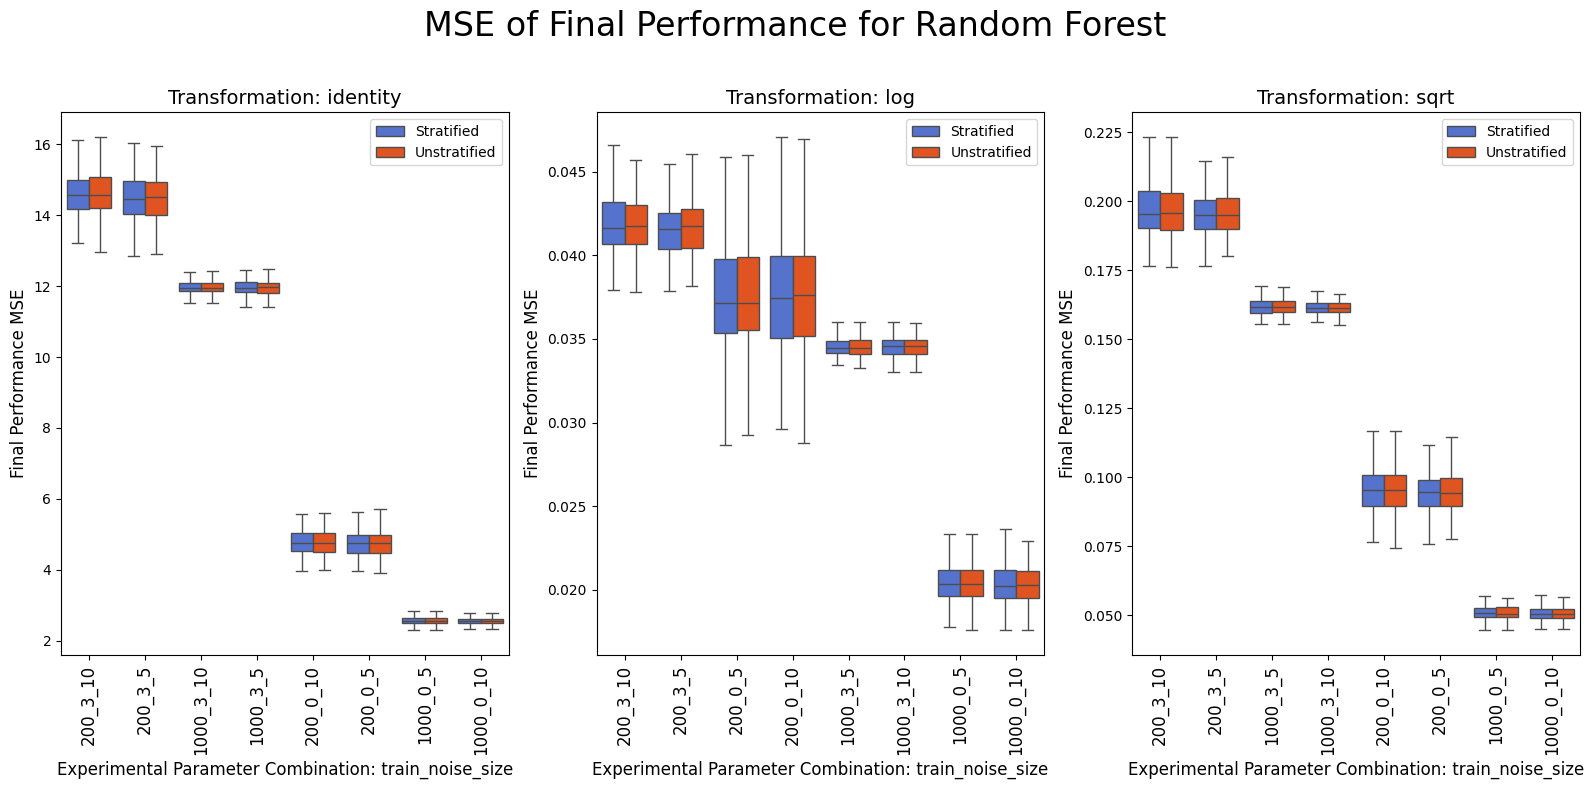

In [16]:
transformations = data['model_info_transformation'].unique()
models = data['model_info_model'].unique()

# rename colum s that startified and unstratified is written at the end
data = data.rename(columns={'stratified_results_test mse': 'MSE_final_perf_stratified', 'unstratified_results_test mse': 'MSE_final_perf_unstratified'}, inplace=False)

    
    # filter data for transformation and model
data_filtered = data[data['model_info_model'] == models[0]]
    # plot
differences_table_all = plot_eval(value_vars= ['MSE_final_perf_stratified', 'MSE_final_perf_unstratified'] , 
                                           value_name = 'Final Performance MSE', 
                                           data = data_filtered, model_vars_title = '_'.join(model_vars_title), nrows=1, ncols=3,
                                           transformations = transformations, model = 'rf')

In [17]:
differences_table_all

,Experimental Hyperparameter Combination,Difference Mean,Difference SD,Stratified Mean,Unstratified Mean
6,200_3_10,5.000565e-03,1.636708e-02,14.642556,14.637556
0,1000_0_10,2.310432e-03,1.591535e-03,2.546733,2.544422
3,1000_3_5,1.733139e-03,7.959667e-03,11.966105,11.964371
5,200_0_5,-6.504909e-04,-7.778265e-03,4.751784,4.752435
1,1000_0_5,-8.409181e-04,-4.395921e-04,2.558297,2.559138
4,200_0_10,-2.960365e-03,-4.664663e-04,4.778563,4.781524
2,1000_3_10,-5.436268e-03,-3.354421e-03,11.963505,11.968941
7,200_3_5,-1.319047e-02,-1.726980e-03,14.482579,14.495769
5,200_0_5,4.331385e-05,9.401129e-05,0.037801,0.037758
3,1000_3_5,1.687900e-05,-2.211062e-05,0.034536,0.034519


  Experimental Hyperparameter Combination  Difference Mean  Difference SD  \
3                                1000_3_5         0.038192       0.026224   
2                               1000_3_10         0.019491       0.020853   
1                                1000_0_5         0.010136       0.012020   
7                                 200_3_5         0.004468       0.045564   
5                                 200_0_5        -0.000895       0.014166   
4                                200_0_10        -0.002881       0.004485   
0                               1000_0_10        -0.007913       0.003494   
6                                200_3_10        -0.051725      -0.050925   

   Stratified Mean  Unstratified Mean  
3        10.996778          10.958586  
2        10.927986          10.908494  
1         0.896512           0.886376  
7        13.549402          13.544934  
5         2.486034           2.486929  
4         2.489376           2.492257  
0         0.878039        

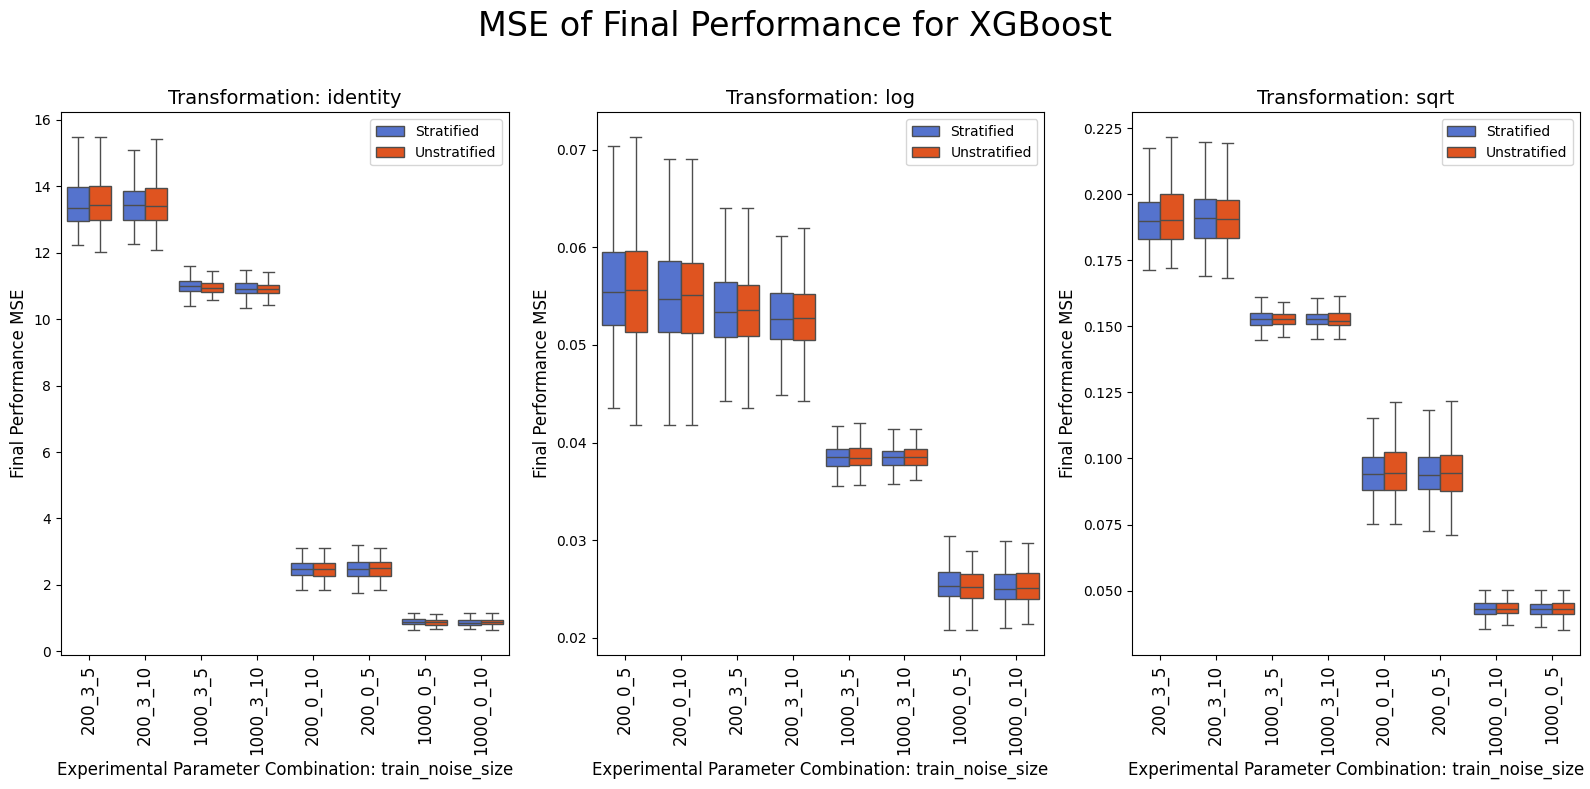

In [19]:
# rename colum s that startified and unstratified is written at the end
data = data.rename(columns={'stratified_results_test mse': 'MSE_final_perf_stratified', 'unstratified_results_test mse': 'MSE_final_perf_unstratified'}, inplace=False)

    
    # filter data for transformation and model
data_filtered = data[data['model_info_model'] == models[1]]
    # plot
differences_table_all = plot_eval(value_vars= ['MSE_final_perf_stratified', 'MSE_final_perf_unstratified'] , 
                                           value_name = 'Final Performance MSE', 
                                           data = data_filtered, model_vars_title = '_'.join(model_vars_title), nrows=1, ncols=3,
                                           transformations = transformations, model = 'xgb')

In [39]:
differences_table_all

,Experimental Hyperparameter Combination,Difference Mean,Difference SD,Stratified Mean,Unstratified Mean
3,1000_3_5,0.038192,0.026224,10.996778,10.958586
2,1000_3_10,0.019491,0.020853,10.927986,10.908494
1,1000_0_5,0.010136,0.012020,0.896512,0.886376
7,200_3_5,0.004468,0.045564,13.549402,13.544934
5,200_0_5,-0.000895,0.014166,2.486034,2.486929
4,200_0_10,-0.002881,0.004485,2.489376,2.492257
0,1000_0_10,-0.007913,0.003494,0.878039,0.885952
6,200_3_10,-0.051725,-0.050925,13.464484,13.516209
5,200_0_5,0.000107,-0.000041,0.055980,0.055873
1,1000_0_5,0.000075,0.000283,0.025468,0.025393


  Experimental Hyperparameter Combination  Difference Mean  Difference SD  \
7                                 200_3_5         0.000402      -0.000053   
2                               1000_3_10         0.000166      -0.000102   
4                                200_0_10         0.000124      -0.000020   
1                                1000_0_5         0.000035      -0.000018   
5                                 200_0_5         0.000027      -0.000326   
3                                1000_3_5        -0.000053       0.000242   
0                               1000_0_10        -0.000097       0.000067   
6                                200_3_10        -0.000152       0.000498   

   Stratified Mean  Unstratified Mean  
7         0.558972           0.558570  
2         0.635683           0.635518  
4         0.799862           0.799738  
1         0.892852           0.892817  
5         0.800984           0.800956  
3         0.635604           0.635657  
0         0.893337        

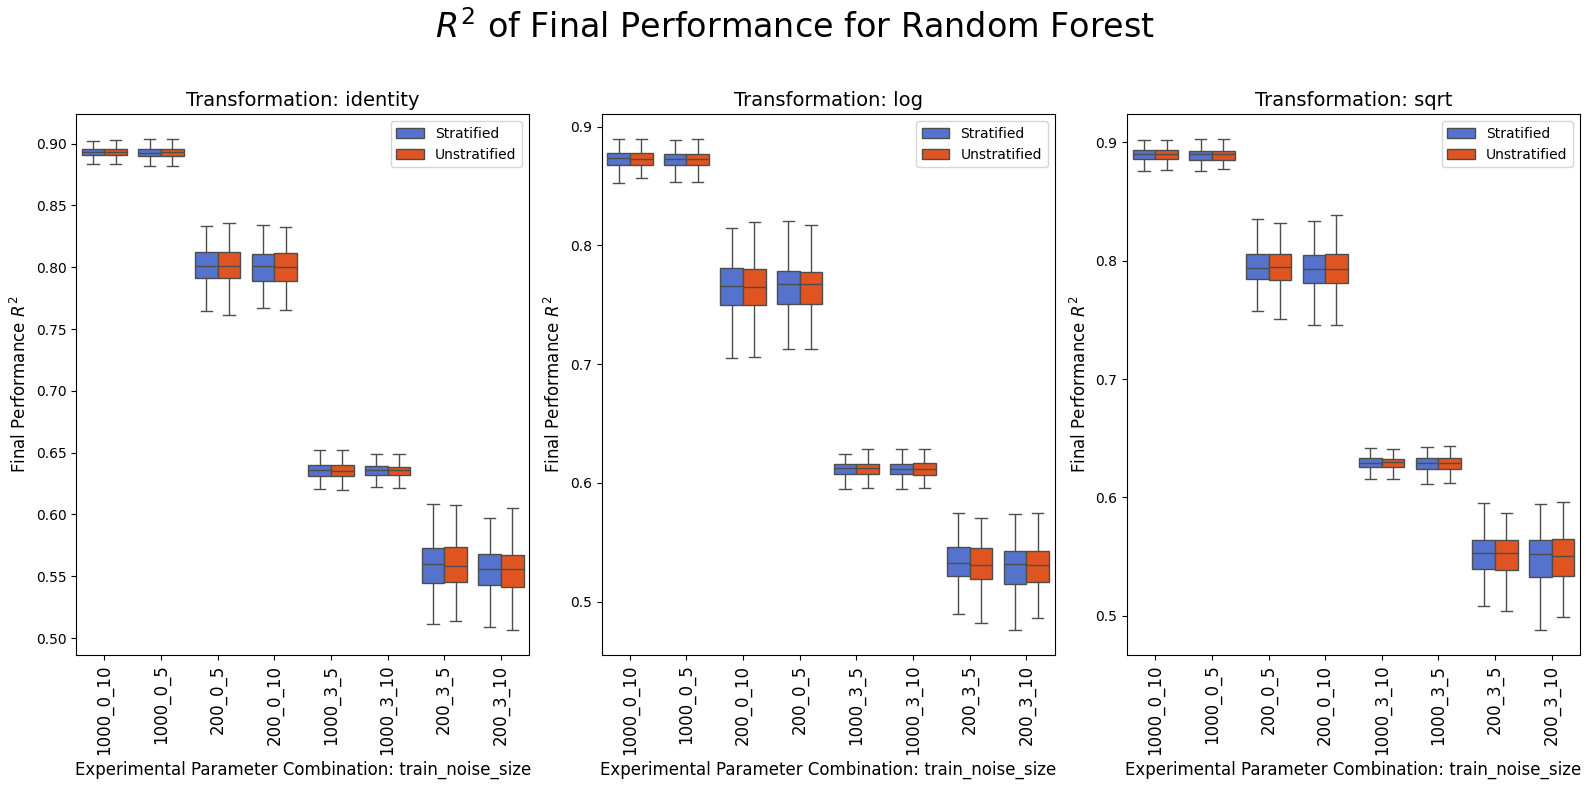

In [20]:
# rename colum s that startified and unstratified is written at the end
data = data.rename(columns={'stratified_results_test r2': 'r2_final_perf_stratified', 'unstratified_results_test r2': 'r2_final_perf_unstratified'}, inplace=False)

    
    # filter data for transformation and model
data_filtered = data[data['model_info_model'] == models[0]]
    # plot
differences_table_all = plot_eval(value_vars= ['r2_final_perf_stratified', 'r2_final_perf_unstratified'] , 
                                           value_name = 'Final Performance $R^2$', 
                                           data = data_filtered, model_vars_title = '_'.join(model_vars_title), nrows=1, ncols=3,
                                           transformations = transformations, model = 'rf', measure = "$R^2$")

In [41]:
differences_table_all

,Experimental Hyperparameter Combination,Difference Mean,Difference SD,Stratified Mean,Unstratified Mean
7,200_3_5,0.000402,-0.000053,0.558972,0.558570
2,1000_3_10,0.000166,-0.000102,0.635683,0.635518
4,200_0_10,0.000124,-0.000020,0.799862,0.799738
1,1000_0_5,0.000035,-0.000018,0.892852,0.892817
5,200_0_5,0.000027,-0.000326,0.800984,0.800956
3,1000_3_5,-0.000053,0.000242,0.635604,0.635657
0,1000_0_10,-0.000097,0.000067,0.893337,0.893433
6,200_3_10,-0.000152,0.000498,0.554100,0.554252
7,200_3_5,0.001070,-0.000387,0.531665,0.530595
4,200_0_10,0.000339,0.000376,0.765001,0.764662


  Experimental Hyperparameter Combination  Difference Mean  Difference SD  \
6                                200_3_10         0.001575      -0.001551   
0                               1000_0_10         0.000331       0.000146   
4                                200_0_10         0.000121       0.000188   
5                                 200_0_5         0.000037       0.000593   
7                                 200_3_5        -0.000136       0.001388   
1                                1000_0_5        -0.000425       0.000503   
2                               1000_3_10        -0.000594       0.000635   
3                                1000_3_5        -0.001163       0.000799   

   Stratified Mean  Unstratified Mean  
6         0.589975           0.588400  
0         0.963226           0.962894  
4         0.895739           0.895618  
5         0.895879           0.895841  
7         0.587389           0.587525  
1         0.962452           0.962876  
2         0.667217        

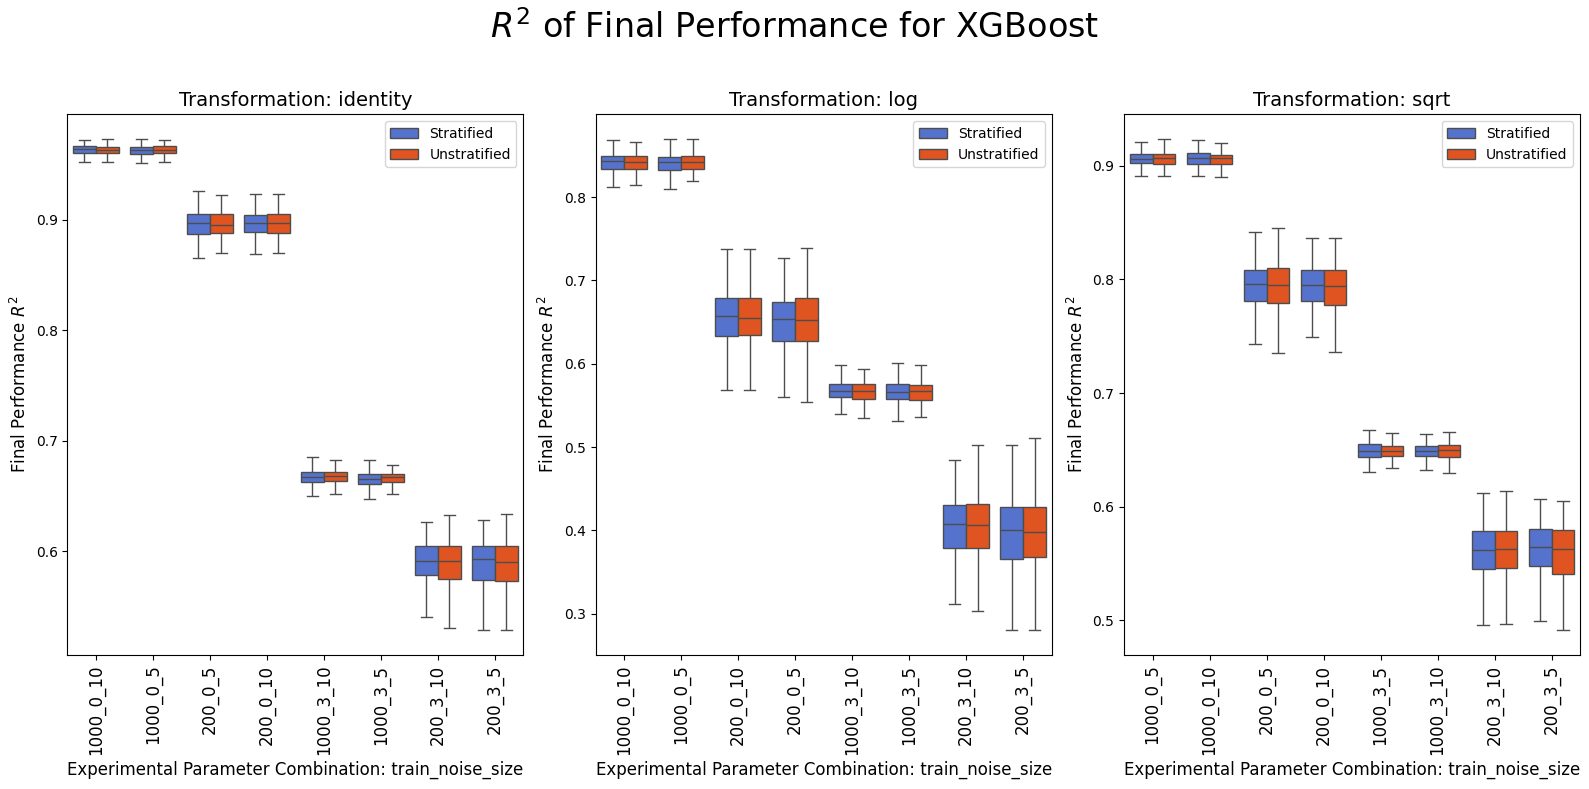

In [21]:
# rename colum s that startified and unstratified is written at the end
data = data.rename(columns={'stratified_results_test r2': 'r2_final_perf_stratified', 'unstratified_results_test r2': 'r2_final_perf_unstratified'}, inplace=False)

    
    # filter data for transformation and model
data_filtered = data[data['model_info_model'] == models[1]]
    # plot
differences_table_all = plot_eval(value_vars= ['r2_final_perf_stratified', 'r2_final_perf_unstratified'] , 
                                           value_name = 'Final Performance $R^2$', 
                                           data = data_filtered, model_vars_title = '_'.join(model_vars_title), nrows=1, ncols=3,
                                           transformations = transformations, model = 'xgb', measure = "$R^2$")

In [22]:
differences_table_all

,Experimental Hyperparameter Combination,Difference Mean,Difference SD,Stratified Mean,Unstratified Mean
6,200_3_10,0.001575,-0.001551,0.589975,0.588400
0,1000_0_10,0.000331,0.000146,0.963226,0.962894
4,200_0_10,0.000121,0.000188,0.895739,0.895618
5,200_0_5,0.000037,0.000593,0.895879,0.895841
7,200_3_5,-0.000136,0.001388,0.587389,0.587525
1,1000_0_5,-0.000425,0.000503,0.962452,0.962876
2,1000_3_10,-0.000594,0.000635,0.667217,0.667811
3,1000_3_5,-0.001163,0.000799,0.665122,0.666285
7,200_3_5,0.000887,0.000599,0.397175,0.396288
4,200_0_10,0.000837,-0.000385,0.656326,0.655489


In [23]:
differences_table_all.sort_values(by = "Difference Mean", ascending = False, inplace=False)

,Experimental Hyperparameter Combination,Difference Mean,Difference SD,Stratified Mean,Unstratified Mean
7,200_3_5,0.003137,-0.003931,0.562027,0.558891
6,200_3_10,0.001575,-0.001551,0.589975,0.588400
4,200_0_10,0.001212,-0.001351,0.794333,0.793121
6,200_3_10,0.001093,-0.002305,0.560492,0.559399
7,200_3_5,0.000887,0.000599,0.397175,0.396288
4,200_0_10,0.000837,-0.000385,0.656326,0.655489
0,1000_0_10,0.000610,0.000141,0.906204,0.905594
0,1000_0_10,0.000558,-0.000127,0.841990,0.841432
6,200_3_10,0.000437,-0.002978,0.402150,0.401713
0,1000_0_10,0.000331,0.000146,0.963226,0.962894


  Experimental Hyperparameter Combination  Difference Mean  Difference SD  \
3                                1000_3_5         0.004164       0.003001   
1                                1000_0_5         0.003348       0.003790   
2                               1000_3_10         0.002067       0.002808   
7                                 200_3_5         0.000488       0.004389   
5                                 200_0_5        -0.000666       0.004139   
4                                200_0_10        -0.000738       0.002164   
0                               1000_0_10        -0.003840       0.000823   
6                                200_3_10        -0.005299      -0.004395   

   Stratified Mean  Unstratified Mean  
3         2.645429           2.641265  
1         0.736776           0.733428  
2         2.637032           2.634965  
7         2.931357           2.930869  
5         1.227642           1.228308  
4         1.229540           1.230278  
0         0.730832        

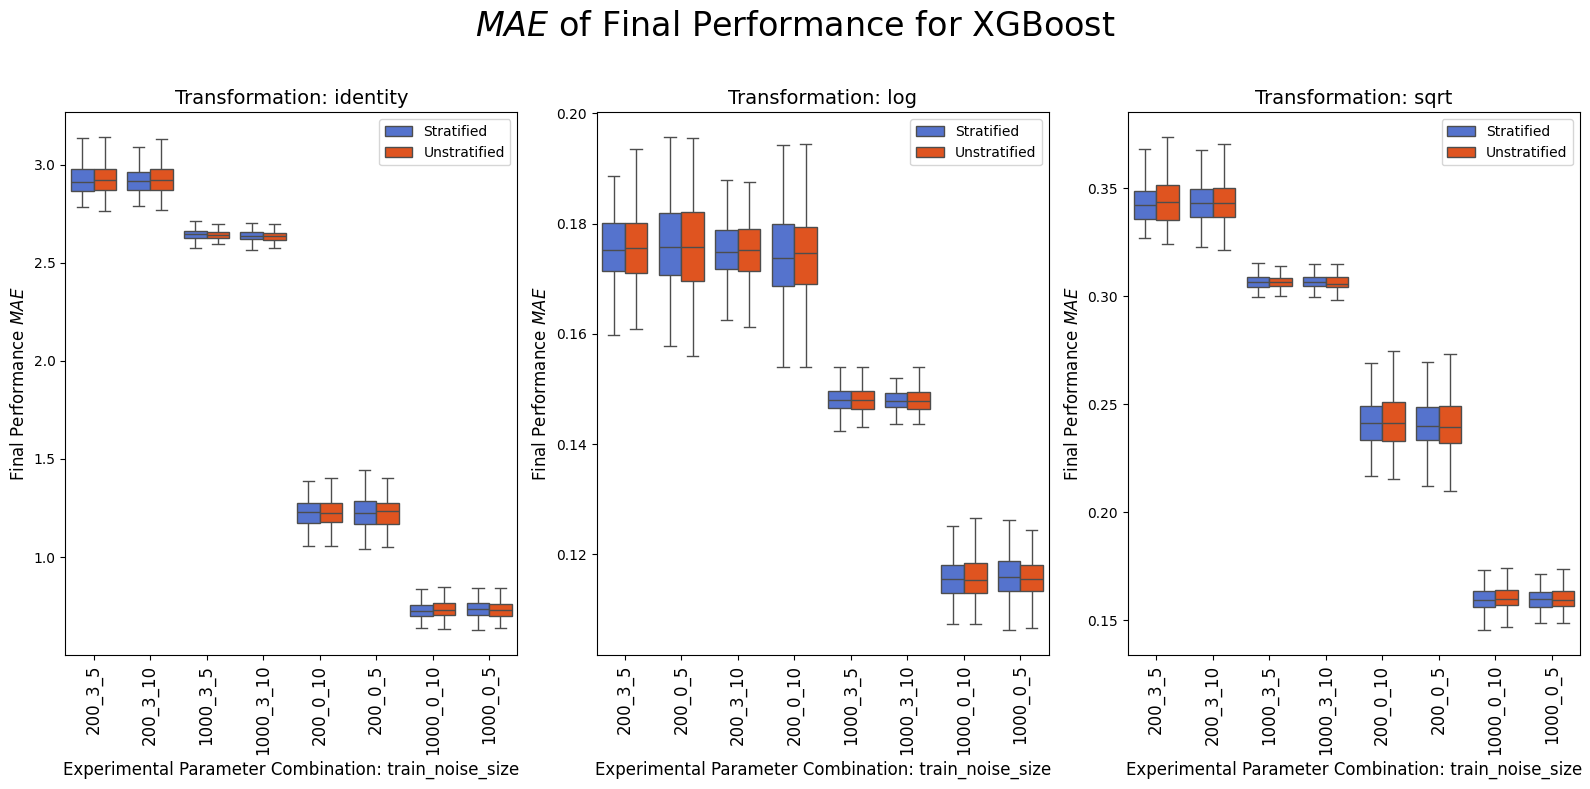

In [24]:
# rename colum s that startified and unstratified is written at the end
data = data.rename(columns={'stratified_results_test mae': 'MAE_final_perf_stratified', 'unstratified_results_test mae': 'MAE_final_perf_unstratified'}, inplace=False)

    
    # filter data for transformation and model
data_filtered = data[data['model_info_model'] == models[1]]
    # plot
differences_table_all = plot_eval(value_vars= ['MAE_final_perf_stratified', 'MAE_final_perf_unstratified'] , 
                                           value_name = 'Final Performance $MAE$', 
                                           data = data_filtered, model_vars_title = '_'.join(model_vars_title), nrows=1, ncols=3,
                                           transformations = transformations, model = 'xgb', measure = "$MAE$")

In [25]:
differences_table_all

,Experimental Hyperparameter Combination,Difference Mean,Difference SD,Stratified Mean,Unstratified Mean
3,1000_3_5,0.004164,0.003001,2.645429,2.641265
1,1000_0_5,0.003348,0.003790,0.736776,0.733428
2,1000_3_10,0.002067,0.002808,2.637032,2.634965
7,200_3_5,0.000488,0.004389,2.931357,2.930869
5,200_0_5,-0.000666,0.004139,1.227642,1.228308
4,200_0_10,-0.000738,0.002164,1.229540,1.230278
0,1000_0_10,-0.003840,0.000823,0.730832,0.734673
6,200_3_10,-0.005299,-0.004395,2.924143,2.929442
1,1000_0_5,0.000285,0.000343,0.116069,0.115784
5,200_0_5,0.000124,-0.000387,0.176090,0.175967


  Experimental Hyperparameter Combination  Difference Mean  Difference SD  \
0                               1000_0_10         0.000570       0.000234   
6                                200_3_10         0.000472       0.001661   
3                                1000_3_5         0.000160       0.000825   
5                                 200_0_5         0.000142      -0.001772   
1                                1000_0_5        -0.000147      -0.000260   
4                                200_0_10        -0.000655       0.000139   
2                               1000_3_10        -0.000679      -0.000428   
7                                 200_3_5        -0.001403      -0.000119   

   Stratified Mean  Unstratified Mean  
0         1.259281           1.258711  
6         3.051215           3.050743  
3         2.757368           2.757208  
5         1.736697           1.736555  
1         1.263419           1.263565  
4         1.741401           1.742056  
2         2.757432        

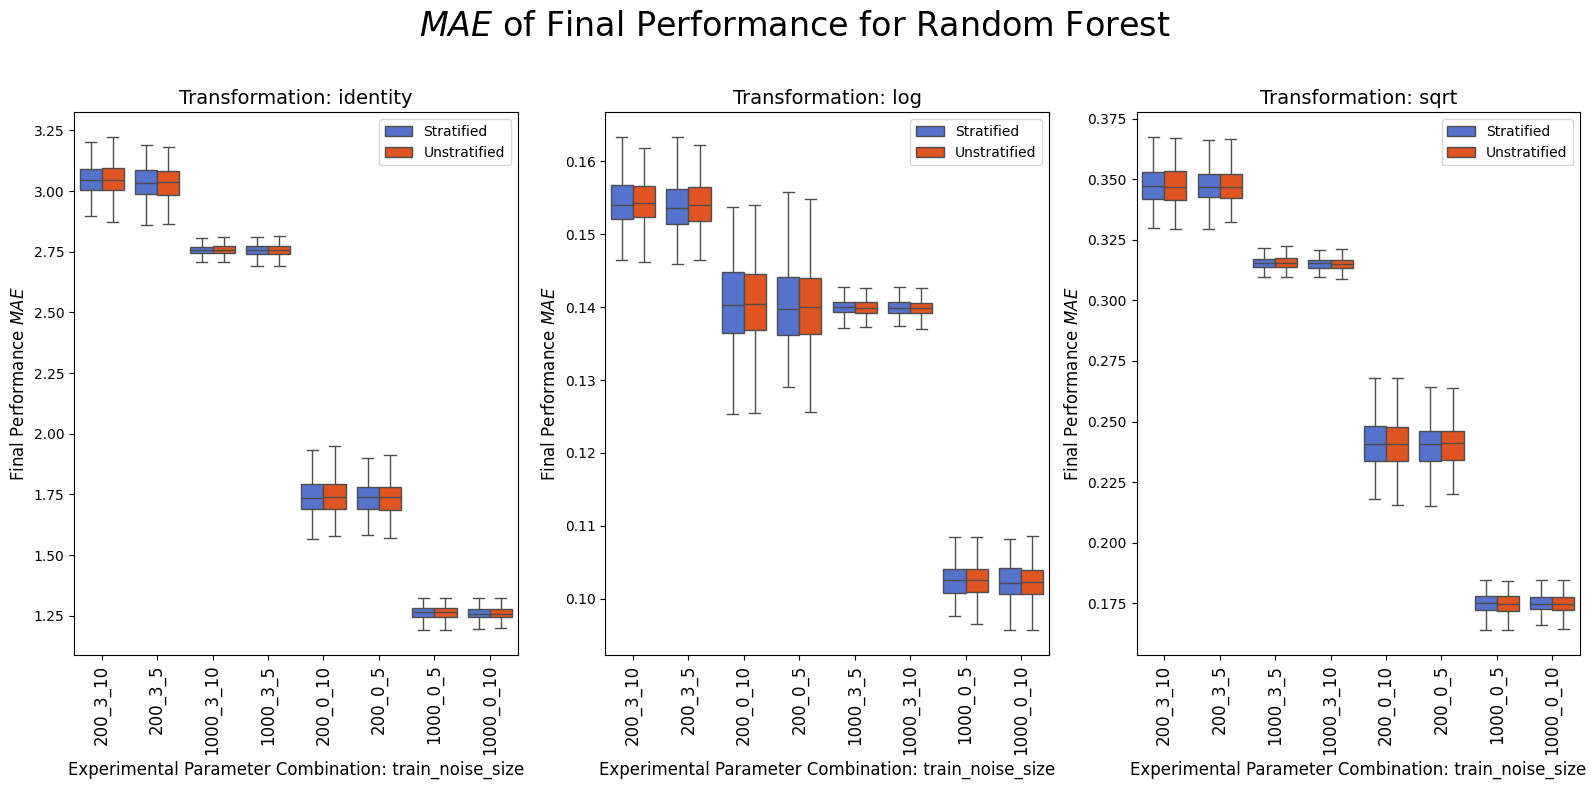

In [26]:
# rename colum s that startified and unstratified is written at the end
data = data.rename(columns={'stratified_results_test mae': 'MAE_final_perf_stratified', 'unstratified_results_test mae': 'MAE_final_perf_unstratified'}, inplace=False)

    
    # filter data for transformation and model
data_filtered = data[data['model_info_model'] == models[0]]
    # plot
differences_table_all = plot_eval(value_vars= ['MAE_final_perf_stratified', 'MAE_final_perf_unstratified'] , 
                                           value_name = 'Final Performance $MAE$', 
                                           data = data_filtered, model_vars_title = '_'.join(model_vars_title), nrows=1, ncols=3,
                                           transformations = transformations, model = 'rf', measure = "$MAE$")

In [27]:
differences_table_all

,Experimental Hyperparameter Combination,Difference Mean,Difference SD,Stratified Mean,Unstratified Mean
0,1000_0_10,0.000570,0.000234,1.259281,1.258711
6,200_3_10,0.000472,0.001661,3.051215,3.050743
3,1000_3_5,0.000160,0.000825,2.757368,2.757208
5,200_0_5,0.000142,-0.001772,1.736697,1.736555
1,1000_0_5,-0.000147,-0.000260,1.263419,1.263565
4,200_0_10,-0.000655,0.000139,1.741401,1.742056
2,1000_3_10,-0.000679,-0.000428,2.757432,2.758110
7,200_3_5,-0.001403,-0.000119,3.034408,3.035812
3,1000_3_5,0.000052,-0.000009,0.139977,0.139925
5,200_0_5,0.000048,0.000195,0.140562,0.140515
